In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution u = H
def exact_solution_h(x, y, t):
    return -torch.sin(x)*torch.sin(y)*torch.cos(t)

def initial_condition_h(x, y):
    return -torch.sin(x)*torch.sin(y) 

In [3]:
# Define the exact solution p = E
def exact_solution_e1(x, y, t):
    return -torch.sin(x)*torch.sin(t)*torch.cos(y)

def initial_condition_e1(x, y):
    return 0.0*torch.sin(x) 

In [4]:
# Define the exact solution p = E
def exact_solution_e2(x, y, t):
    return torch.sin(y)*torch.sin(t)*torch.cos(x)

def initial_condition_e2(x, y):
    return 0.0*torch.sin(x) 

In [5]:
# assigning number of points
initial_pts = 200 
left_boundary_pts = 200 
right_boundary_pts = 200
back_boundary_pts = 200
front_boundary_pts = 200
residual_pts = 1000

In [6]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

x_init = torch.rand((initial_pts,1)) # initial pts
y_init = torch.rand((initial_pts,1))
t_init =  0*x_init
init =  torch.cat([x_init, y_init, t_init],1)
h_init = initial_condition_h(init[:,0], init[:, 1]).reshape(-1, 1)
e1_init = initial_condition_e1(init[:,0], init[:, 1]).reshape(-1, 1)
e2_init = initial_condition_e2(init[:,0], init[:, 1]).reshape(-1, 1)
w_init = torch.cat([h_init, e1_init, e2_init],1)


xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
yb_left = torch.rand((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, yb_left, tb_left ],1)
h_b_l = exact_solution_h(xb_left, yb_left, tb_left).reshape(-1, 1)
e1_b_l = exact_solution_e1(xb_left, yb_left, tb_left).reshape(-1, 1)
e2_b_l = exact_solution_e2(xb_left, yb_left, tb_left).reshape(-1, 1)



xb_right = torch.ones((right_boundary_pts, 1)) # right spatial boundary
yb_right = torch.rand((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, yb_right, tb_right ],1)
h_b_r = exact_solution_h(xb_right, yb_right, tb_right).reshape(-1, 1)
e1_b_r = exact_solution_e1(xb_right, yb_right, tb_right).reshape(-1, 1)
e2_b_r = exact_solution_e2(xb_right, yb_right, tb_right).reshape(-1, 1)



xb_front = torch.rand((front_boundary_pts, 1)) # front spatial boundary
yb_front = torch.zeros((front_boundary_pts, 1)) # front spatial boundary
tb_front = torch.rand((front_boundary_pts, 1)) # 
b_front = torch.cat([xb_front, yb_front, tb_front ],1)
h_b_f = exact_solution_h(xb_front, yb_front, tb_front).reshape(-1, 1)
e1_b_f = exact_solution_e1(xb_front, yb_front, tb_front).reshape(-1, 1)
e2_b_f = exact_solution_e2(xb_front, yb_front, tb_front).reshape(-1, 1)



xb_back = torch.rand((back_boundary_pts, 1)) # back spatial boundary
yb_back = torch.ones((back_boundary_pts, 1)) # back spatial boundary
tb_back = torch.rand((back_boundary_pts, 1)) # back boundary pts
b_back = torch.cat([xb_back, yb_back, tb_back ],1)
h_b_b = exact_solution_h(xb_back, yb_back, tb_back).reshape(-1, 1)
e1_b_b = exact_solution_e1(xb_back, yb_back, tb_back).reshape(-1, 1)
e2_b_b = exact_solution_e2(xb_back, yb_back, tb_back).reshape(-1, 1)



x_interior = torch.rand((residual_pts, 1))
y_interior = torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, y_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, b_left,  b_right, b_front, b_back), batch_size=200, shuffle=False)

In [7]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [8]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1], n_hidden_layers=4, neurons=20)


In [9]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [10]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [11]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, bd_left,  bd_right, bd_front, bd_back) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                h_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                e1_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                e2_initial_pred_ = w_initial_pred_[:,2].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_h_ini = torch.autograd.grad(h_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                h_initial_t = grad_h_ini[:, 2]
                
                grad_e1_ini = torch.autograd.grad(e1_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                e1_initial_t = grad_e1_ini[:, 2]
                
                grad_e2_ini = torch.autograd.grad(e2_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                e2_initial_t = grad_e2_ini[:, 2]
                
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                h_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                e1_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                e2_bd_left_pred_ = w_bd_left_pred_[:,2].reshape(-1,1)
                
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                h_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                e1_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                e2_bd_right_pred_ = w_bd_right_pred_[:,2].reshape(-1,1)
                
                # for front boundary
                w_bd_front_pred_ = model(bd_front)
                h_bd_front_pred_ = w_bd_front_pred_[:,0].reshape(-1,1)
                e1_bd_front_pred_ = w_bd_front_pred_[:,1].reshape(-1,1)
                e2_bd_front_pred_ = w_bd_front_pred_[:,2].reshape(-1,1)
                
                # for back boundary
                w_bd_back_pred_ = model(bd_back)
                h_bd_back_pred_ = w_bd_back_pred_[:,0].reshape(-1,1)
                e1_bd_back_pred_ = w_bd_back_pred_[:,1].reshape(-1,1)
                e2_bd_back_pred_ = w_bd_back_pred_[:,2].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                h_hat = w_hat[:,0].reshape(-1,1)
                e1_hat = w_hat[:,1].reshape(-1,1)
                e2_hat = w_hat[:,2].reshape(-1,1)
                
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                
                grad_h_hat = torch.autograd.grad(h_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                h_x = grad_h_hat[:, 0].reshape(-1,1)
                h_y = grad_h_hat[:, 1].reshape(-1,1)
                
                grad_e1_hat = torch.autograd.grad(e1_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                e1_x = grad_e1_hat[:, 0].reshape(-1,1)
                e1_y = grad_e1_hat[:, 1].reshape(-1,1)
                
                grad_e2_hat = torch.autograd.grad(e2_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                e2_x = grad_e2_hat[:, 0].reshape(-1,1)
                e2_y = grad_e2_hat[:, 1].reshape(-1,1)
                
                h_t = grad_h_hat[:, 2].reshape(-1,1)
                e1_t = grad_e1_hat[:, 2].reshape(-1,1)
                e2_t = grad_e2_hat[:, 2].reshape(-1,1)
                
                
                # Item 1. below
                loss1 = torch.mean((h_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + torch.mean((2*h_t.reshape(-1, ) + e2_x.reshape(-1, ) - e1_y.reshape(-1, ))**p)+torch.mean((h_bd_left_pred_.reshape(-1,)- h_b_l.reshape(-1,))**p) + torch.mean((h_bd_right_pred_.reshape(-1,)- h_b_r.reshape(-1,))**p) +torch.mean((h_bd_front_pred_.reshape(-1,)- h_b_f.reshape(-1,))**p) + torch.mean((h_bd_back_pred_.reshape(-1,)- h_b_b.reshape(-1,))**p)
                loss2 = torch.mean((e1_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((4*e1_t.reshape(-1, ) + 2*e2_t.reshape(-1, ) - h_y.reshape(-1, ) + 3*torch.sin(interior[:, 0])*torch.cos(interior[:, 2])*torch.cos(interior[:, 1]) - 2*torch.cos(interior[:, 0])*torch.cos(interior[:, 2])*torch.sin(interior[:, 1]) )**p) +torch.mean((e1_bd_left_pred_.reshape(-1,)- e1_b_l.reshape(-1,))**p) + torch.mean((e1_bd_right_pred_.reshape(-1,)- e1_b_r.reshape(-1,))**p) +torch.mean((e1_bd_front_pred_.reshape(-1,)- e1_b_f.reshape(-1,))**p) + torch.mean((e1_bd_back_pred_.reshape(-1,)- e1_b_b.reshape(-1,))**p)
                loss3 = torch.mean((e2_initial_pred_.reshape(-1, ) - w_initial[:,2].reshape(-1, ))**p)+ torch.mean((2*e1_t.reshape(-1, ) + e2_t.reshape(-1, )  + h_x.reshape(-1, ) + 2*torch.sin(interior[:, 0])*torch.cos(interior[:, 2])*torch.cos(interior[:, 1]))**p) +torch.mean((e2_bd_left_pred_.reshape(-1,)- e2_b_l.reshape(-1,))**p) + torch.mean((e2_bd_right_pred_.reshape(-1,)- e2_b_r.reshape(-1,))**p) +torch.mean((e2_bd_front_pred_.reshape(-1,)- e2_b_f.reshape(-1,))**p) + torch.mean((e2_bd_back_pred_.reshape(-1,)- e2_b_b.reshape(-1,))**p)
                loss = loss1 + loss2 + loss3
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [12]:
n_epochs = 1500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  195.86463928222656
################################  1  ################################
Loss:  191.5936737060547
################################  2  ################################
Loss:  163.11566162109375
################################  3  ################################
Loss:  132.72230529785156
################################  4  ################################
Loss:  101.83101654052734
################################  5  ################################
Loss:  77.85144805908203
################################  6  ################################
Loss:  64.0369873046875
################################  7  ################################
Loss:  55.33611297607422
################################  8  ################################
Loss:  48.68509292602539
################################  9  ################################
Loss:  43.05506134033203
################################  10  #########

Loss:  0.0313430055975914
################################  91  ################################
Loss:  0.029931198805570602
################################  92  ################################
Loss:  0.028557434678077698
################################  93  ################################
Loss:  0.027216553688049316
################################  94  ################################
Loss:  0.02599407359957695
################################  95  ################################
Loss:  0.024950657039880753
################################  96  ################################
Loss:  0.023984018713235855
################################  97  ################################
Loss:  0.02308110147714615
################################  98  ################################
Loss:  0.02223317325115204
################################  99  ################################
Loss:  0.021444186568260193
################################  100  ################################
Loss:  0.02070

Loss:  0.004266258329153061
################################  186  ################################
Loss:  0.004219978116452694
################################  187  ################################
Loss:  0.004174933768808842
################################  188  ################################
Loss:  0.004131980240345001
################################  189  ################################
Loss:  0.004088263027369976
################################  190  ################################
Loss:  0.00404370715841651
################################  191  ################################
Loss:  0.0039980122819542885
################################  192  ################################
Loss:  0.003949239384382963
################################  193  ################################
Loss:  0.0039041421841830015
################################  194  ################################
Loss:  0.003857884556055069
################################  195  ################################

Loss:  0.0015979743329808116
################################  279  ################################
Loss:  0.0015862404834479094
################################  280  ################################
Loss:  0.001574201276525855
################################  281  ################################
Loss:  0.0015599408652633429
################################  282  ################################
Loss:  0.0015477745328098536
################################  283  ################################
Loss:  0.0015345190186053514
################################  284  ################################
Loss:  0.0015180762857198715
################################  285  ################################
Loss:  0.0015049793291836977
################################  286  ################################
Loss:  0.0014904967974871397
################################  287  ################################
Loss:  0.0014758927281945944
################################  288  ########################

Loss:  0.0009066604543477297
################################  374  ################################
Loss:  0.0009022317826747894
################################  375  ################################
Loss:  0.0008978464175015688
################################  376  ################################
Loss:  0.0008935326477512717
################################  377  ################################
Loss:  0.0008891670731827617
################################  378  ################################
Loss:  0.0008849102887324989
################################  379  ################################
Loss:  0.0008806554833427072
################################  380  ################################
Loss:  0.0008764768717810512
################################  381  ################################
Loss:  0.0008723473874852061
################################  382  ################################
Loss:  0.0008682911284267902
################################  383  #######################

Loss:  0.0006320595275610685
################################  470  ################################
Loss:  0.0006307232542894781
################################  471  ################################
Loss:  0.0006293647456914186
################################  472  ################################
Loss:  0.0006280118832364678
################################  473  ################################
Loss:  0.0006266196724027395
################################  474  ################################
Loss:  0.0006252322345972061
################################  475  ################################
Loss:  0.0006237939815036952
################################  476  ################################
Loss:  0.0006223515956662595
################################  477  ################################
Loss:  0.0006208306294865906
################################  478  ################################
Loss:  0.0006192490691319108
################################  479  #######################

Loss:  0.0005085249431431293
################################  559  ################################
Loss:  0.000506619515363127
################################  560  ################################
Loss:  0.0005047823651693761
################################  561  ################################
Loss:  0.0005028063897043467
################################  562  ################################
Loss:  0.0005007246509194374
################################  563  ################################
Loss:  0.0004985200939700007
################################  564  ################################
Loss:  0.0004964080872014165
################################  565  ################################
Loss:  0.0004942354862578213
################################  566  ################################
Loss:  0.0004919002531096339
################################  567  ################################
Loss:  0.0004896745085716248
################################  568  ########################

Loss:  0.00036362098762765527
################################  654  ################################
Loss:  0.00036234286380931735
################################  655  ################################
Loss:  0.0003609904379118234
################################  656  ################################
Loss:  0.0003590777050703764
################################  657  ################################
Loss:  0.00035742309410125017
################################  658  ################################
Loss:  0.0003547832020558417
################################  659  ################################
Loss:  0.00035311462124809623
################################  660  ################################
Loss:  0.0003510504902806133
################################  661  ################################
Loss:  0.00034915254218503833
################################  662  ################################
Loss:  0.00034703454002738
################################  663  ####################

Loss:  0.0002664439380168915
################################  743  ################################
Loss:  0.0002656503929756582
################################  744  ################################
Loss:  0.0002648054505698383
################################  745  ################################
Loss:  0.00026407523546367884
################################  746  ################################
Loss:  0.0002634220290929079
################################  747  ################################
Loss:  0.00026269303634762764
################################  748  ################################
Loss:  0.0002620640443637967
################################  749  ################################
Loss:  0.00026125373551622033
################################  750  ################################
Loss:  0.00026038195937871933
################################  751  ################################
Loss:  0.00025937819737009704
################################  752  ##################

Loss:  0.00020461942767724395
################################  826  ################################
Loss:  0.00020412387675605714
################################  827  ################################
Loss:  0.00020363427756819874
################################  828  ################################
Loss:  0.00020310853142291307
################################  829  ################################
Loss:  0.00020260942983441055
################################  830  ################################
Loss:  0.00020210925140418112
################################  831  ################################
Loss:  0.00020162916916888207
################################  832  ################################
Loss:  0.00020114899962209165
################################  833  ################################
Loss:  0.00020071532344445586
################################  834  ################################
Loss:  0.00020029334700666368
################################  835  #############

Loss:  0.00016389910888392478
################################  918  ################################
Loss:  0.0001635714143048972
################################  919  ################################
Loss:  0.00016324801254086196
################################  920  ################################
Loss:  0.00016294224769808352
################################  921  ################################
Loss:  0.00016265377053059638
################################  922  ################################
Loss:  0.00016237562522292137
################################  923  ################################
Loss:  0.00016211633919738233
################################  924  ################################
Loss:  0.00016186098218895495
################################  925  ################################
Loss:  0.0001616193912923336
################################  926  ################################
Loss:  0.0001613870117580518
################################  927  ################

Loss:  0.00013261786079965532
################################  1014  ################################
Loss:  0.00013225359725765884
################################  1015  ################################
Loss:  0.0001318688300671056
################################  1016  ################################
Loss:  0.00013151626626495272
################################  1017  ################################
Loss:  0.00013113129534758627
################################  1018  ################################
Loss:  0.00013072750880382955
################################  1019  ################################
Loss:  0.00013026809028815478
################################  1020  ################################
Loss:  0.0001297628623433411
################################  1021  ################################
Loss:  0.00012922973837703466
################################  1022  ################################
Loss:  0.00012875572429038584
################################  1023  #####

Loss:  0.0001068267083610408
################################  1101  ################################
Loss:  0.00010650924377841875
################################  1102  ################################
Loss:  0.00010619292152114213
################################  1103  ################################
Loss:  0.00010585128620732576
################################  1104  ################################
Loss:  0.00010549958824412897
################################  1105  ################################
Loss:  0.0001051663130056113
################################  1106  ################################
Loss:  0.00010482801008038223
################################  1107  ################################
Loss:  0.00010450267291162163
################################  1108  ################################
Loss:  0.00010417302837595344
################################  1109  ################################
Loss:  0.0001038272021105513
################################  1110  ######

Loss:  8.75531550263986e-05
################################  1189  ################################
Loss:  8.746339881327003e-05
################################  1190  ################################
Loss:  8.736448944546282e-05
################################  1191  ################################
Loss:  8.725948282517493e-05
################################  1192  ################################
Loss:  8.71486627147533e-05
################################  1193  ################################
Loss:  8.703363710083067e-05
################################  1194  ################################
Loss:  8.691721450304613e-05
################################  1195  ################################
Loss:  8.67960843606852e-05
################################  1196  ################################
Loss:  8.667890506330878e-05
################################  1197  ################################
Loss:  8.656040881760418e-05
################################  1198  ################

Loss:  7.50206527300179e-05
################################  1284  ################################
Loss:  7.493823068216443e-05
################################  1285  ################################
Loss:  7.485588866984472e-05
################################  1286  ################################
Loss:  7.472002471331507e-05
################################  1287  ################################
Loss:  7.460828055627644e-05
################################  1288  ################################
Loss:  7.445401570294052e-05
################################  1289  ################################
Loss:  7.427939272020012e-05
################################  1290  ################################
Loss:  7.407903467537835e-05
################################  1291  ################################
Loss:  7.38819144316949e-05
################################  1292  ################################
Loss:  7.365935744019225e-05
################################  1293  ###############

Loss:  6.479882722487673e-05
################################  1388  ################################
Loss:  6.470940570579842e-05
################################  1389  ################################
Loss:  6.457975541707128e-05
################################  1390  ################################
Loss:  6.451233639381826e-05
################################  1391  ################################
Loss:  6.444421160267666e-05
################################  1392  ################################
Loss:  6.436671537812799e-05
################################  1393  ################################
Loss:  6.427206244552508e-05
################################  1394  ################################
Loss:  6.419391138479114e-05
################################  1395  ################################
Loss:  6.410706555470824e-05
################################  1396  ################################
Loss:  6.400556594599038e-05
################################  1397  #############

Loss:  5.61654451303184e-05
################################  1474  ################################
Loss:  5.6012082495726645e-05
################################  1475  ################################
Loss:  5.584493919741362e-05
################################  1476  ################################
Loss:  5.569527274928987e-05
################################  1477  ################################
Loss:  5.5536678701173514e-05
################################  1478  ################################
Loss:  5.536368189495988e-05
################################  1479  ################################
Loss:  5.519492697203532e-05
################################  1480  ################################
Loss:  5.503667489392683e-05
################################  1481  ################################
Loss:  5.488972965395078e-05
################################  1482  ################################
Loss:  5.474544741446152e-05
################################  1483  ############

In [13]:
# saving and loading Model
FILE = "maxwell2D_3.pth"
torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [14]:
# saving and loading Model (this model with reported results)
#FILE = "second.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [15]:
x_test = torch.linspace(0, 1, 10000).reshape(-1,1)
y_test = torch.linspace(0, 1, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, y_test, t_test],1)
h_test = exact_solution_h(x_test, y_test, t_test).reshape(-1,1)
e1_test = exact_solution_e1(x_test, y_test, t_test).reshape(-1,1)
e2_test = exact_solution_e2(x_test, y_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
h_test_pred = w_test_pred[:,0].reshape(-1,1)
e1_test_pred = w_test_pred[:,1].reshape(-1,1)
e2_test_pred = w_test_pred[:,2].reshape(-1,1)

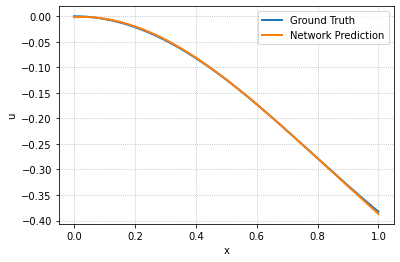

In [16]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, h_test, label="Ground Truth",lw=2)
plt.plot(x_test, h_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [17]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((h_test_pred - h_test)**2)/torch.mean(h_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.004095898475497961 %


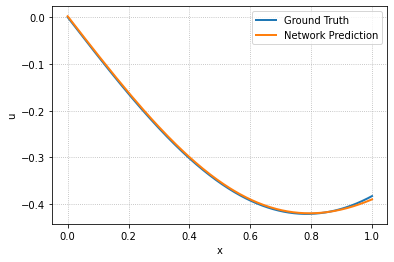

In [18]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, e1_test, label="Ground Truth",lw=2)
plt.plot(x_test, e1_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [19]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((e1_test_pred - e1_test)**2)/torch.mean(e1_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.006403361476259306 %


In [20]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((e2_test_pred - e2_test)**2)/torch.mean(e2_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.026115114451386034 %


In [21]:
# for ploting

In [22]:
model = my_network
x_test = pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)

u_pred1 = u_test_pred[:, 1].reshape(-1,1)


relative_error = torch.abs(u_pred- u_test)

relative_error1 = torch.abs(u_pred1- p_test)
u_pred = u_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
p_pred = u_pred1.detach().numpy()
relative_error = relative_error.detach().numpy()
relative_error1 = relative_error1.detach().numpy()

NameError: name 'exact_solution_u' is not defined

In [ ]:

x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)

In [ ]:

plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, u_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#plt.savefig('timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:
CS = plt.tricontourf(x_test, t_test, p_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('timo_p.png', dpi = 300, bbox_inches = "tight")

In [ ]:

x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)




CS = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:
relative_error1 = relative_error1.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error1, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_p.png', dpi = 300, bbox_inches = "tight")